In [3]:
using PyPlot, StatsBase, Printf, DelimitedFiles
using Revise
using MDToolbox
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/MgvIv/src/Revise.jl:1167
┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260


In [4]:
# setup constants
KBT = KB_kcalpermol*300.0

0.59616123

In [5]:
# umbrella window centers
umbrella_center = 0:3:180
K = length(umbrella_center)

61

In [6]:
# define edges for histogram bin
M = 80; # number of bins
edge = range(-1, stop=181, length=M+1)
#edge = linspace(-1, 181, M+1)
bin_center = 0.5 .* (edge[2:end] .+ edge[1:(end-1)])

0.1375:2.275:179.8625

In [7]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/umbrella_alat/3_prod/run_%d.dat" umbrella_center[k]
  x = readdlm(filename);
  push!(data_k, x[:, 2])
end

In [8]:
# calculate histogram (h_km)
# h_km: histogram (data counts) of k-th umbrella data counts in m-th data bin
h_km = zeros(Int64, K, M)
for k = 1:K
  h = fit(Histogram, data_k[k], edge)
  h_m = h.weights
  h_km[k, :] = h_m
end

In [17]:
# bias-energy
# bias_km: bias-factor of k-th umbrella-window evaluated at m-th bin-center
function minimum_image(center, x)
  dx = x .- center
  dx = dx .- round.(dx./360.0).*360.0;
  dx
end

bias_km = zeros(Float64, K, M)
spring_constant = 200.0 * (pi/180.0)^2; # conversion of the unit from kcal/mol/rad^2 to kcal/mol/deg^2
for k = 1:K
  for m = 1:M
    #bias_km[k, m] = (spring_constant./KBT) * (minimum_image(Float64(umbrella_center[k]), bin_center[m])).^2
    bias_km[k, m] = (spring_constant./KBT) * (Float64(umbrella_center[k]) - bin_center[m]).^2
  end
end

In [18]:
# solve WHAM equations, and
# calculate probabilities in the dihedral angle space, and evaluate the potential of mean force (PMF)
f_k, pmf_m = wham(h_km, bias_km)
pmf_m = KBT .* pmf_m;
pmf_m = pmf_m .- pmf_m[1]

1×80 Array{Float64,2}:
 0.0  -0.0169813  0.0474963  0.00841217  0.119576  …  -6.87585  -7.06385  -7.13125  -7.21599  -7.13709

In [19]:
using JLD2
@save "wham.jld2" bin_center pmf_m

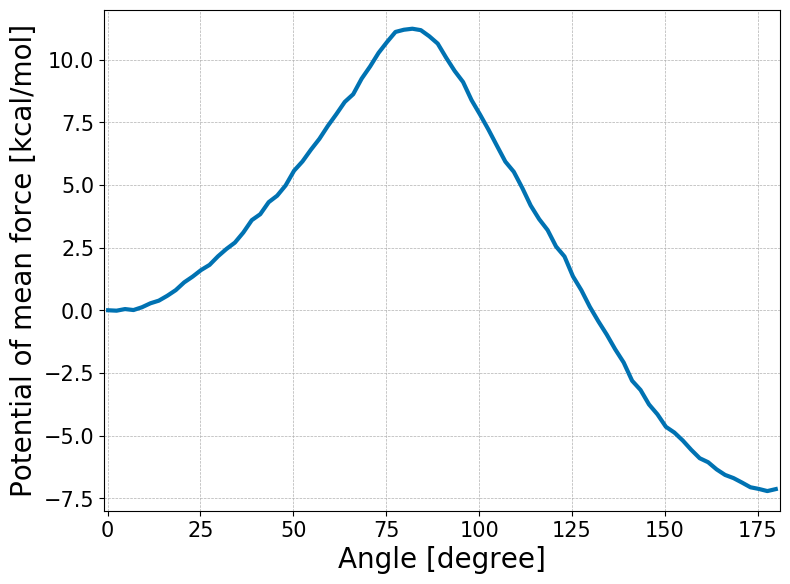

In [20]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(bin_center, pmf_m[:], linewidth=3)
xlabel("Angle [degree]",fontsize=20)
ylabel("Potential of mean force [kcal/mol]",fontsize=20)

# detailed options (not necessary, just for reference)
ax.set(xlim=[-1, 181], ylim=[-8, 12])
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

savefig("wham.png", dpi=350)